In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'swamp_sparrow'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [5]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,rate,spectrogram
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.056673408, 0.0122..."


In [6]:
np.shape(syllable_df.spectrogram.values[0])

(32, 22)

### project

In [7]:
specs = list(syllable_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(97573, 704)

In [8]:
min_dist = 0.5
cuml_umap = cumlUMAP(min_dist = min_dist)
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until


(-15, 15)

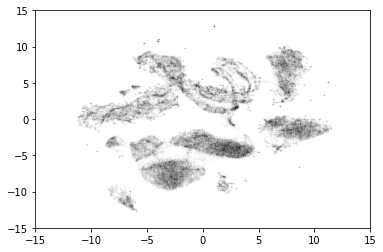

In [12]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 0.01)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [9]:
syllable_df['umap'] = list(embedding)

### Save

In [10]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'full')

In [11]:
syllable_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / (str(min_dist) + '_full.pickle'))